In [40]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
tokenizer = AutoTokenizer.from_pretrained("ISTA-DASLab/Llama-2-7b-AQLM-2Bit-2x8-hf")
model = AutoModelForCausalLM.from_pretrained("ISTA-DASLab/Llama-2-7b-AQLM-2Bit-2x8-hf")
%load_ext autoreload
%autoreload 2

`low_cpu_mem_usage` was None, now set to True since model is quantized.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): QuantizedLinear()
          (k_proj): QuantizedLinear()
          (v_proj): QuantizedLinear()
          (o_proj): QuantizedLinear()
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): QuantizedLinear()
          (up_proj): QuantizedLinear()
          (down_proj): QuantizedLinear()
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)


In [42]:
activations = {}
def capture_output(module, input, output):
    activations['layer_13_output'] = output[0].detach()
    
hook = model.model.layers[13].register_forward_hook(capture_output)

In [4]:
input_text = "paris is in france"
input_token = tokenizer.encode_plus(input_text, return_tensors="pt")

input_ids = input_token["input_ids"]
mask = input_token["attention_mask"]

In [5]:
with torch.no_grad():
    output = model(input_ids=input_ids, attention_mask=mask)
    
layer_13_output = activations['layer_13_output']
hook.remove()

In [6]:
layer_13_output.shape , input_ids

(torch.Size([1, 7, 4096]),
 tensor([[   1,  610,  275,  338,  297, 2524,  346]]))

- dimension 0 : taille du batch
- dimension 1 : taille de la séquence
- dimension 2 : taille de la représentation

On aura donc des tailles variables de sortie en fonction de la taille de la séquence d'entrée. 

Comment faire pour l'utiliser pour la classification ?

- utiliser le token `[CLS]` (modéle basé sur bert) qui est le premier token de la séquence (espece de représentation de la séquence entière) nous on est sur sententpiece `<s>` pas le meme role mais peut etre qu'on peut l'utiliser de la meme facon
- average pooling : moyenne des représentations des tokens de la séquence
- max pooling : max des représentations des tokens de la séquence
- system d'attention : on va donner un poids à chaque token de la séquence et on va faire une somme pondérée des représentations des tokens

In [7]:
encoded_input = tokenizer("Exemple de texte", return_tensors="pt")
print("Tokens encodés:", encoded_input)

tokenizer.decode(encoded_input["input_ids"].tolist()[0])

Tokens encodés: {'input_ids': tensor([[    1,  1222,   331,   552,   316, 19696,   371]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


'<s> Exemple de texte'

In [37]:
from attention import AutoAttentionFixeOutput

attention = AutoAttentionFixeOutput()

attention_output = attention.forward(layer_13_output)

In [38]:
attention_output.shape

torch.Size([2])

## Creating the dataset of weights

In [39]:
import pandas as pd
raw_data = pd.read_csv("data/publicDataset/facts_true_false.csv")
raw_data.head() 

,statement,label
0,The planet Uranus is tilted on its side.,1
1,Sharks are sea creatures that have a reputatio...,1
2,An adult human has 32 teeth.,1
3,The smallest continent in the world is Australia.,1
4,The Amazon River is the largest river in the w...,1


In [ ]:
activations = {}
class StopForwardException(Exception):
    pass

def capture_output(module, input, output):
    activations['layer_13_output'] = output[0].detach()
    raise StopForwardException()
    
    
hook = model.model.layers[13].register_forward_hook(capture_output)
for i in range(51,raw_data.shape[0]) :
    try :
        statement = raw_data.iloc[i,0]
        label = raw_data.iloc[i,1]
        
        input_token = tokenizer.encode_plus(input_text, return_tensors="pt")
        input_ids = input_token["input_ids"]
        mask = input_token["attention_mask"]
        
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=mask)
    except StopForwardException:
        pass
    
    layer_13_output = activations['layer_13_output'].squeeze(0)
    layer_13_output = layer_13_output.numpy()
    layer_13_output = pd.DataFrame(layer_13_output)
    layer_13_output["label"] = label
    layer_13_output["object_number"]=i
    
    layer_13_output.to_csv("data/layer_13_output.csv", mode='a', header=False, index=False)
    print(f"Line {i} done")
    

In [154]:
df = pd.read_csv("data/layer_13_output.csv", header=None)

In [155]:
df.shape

(357, 4098)

In [156]:
#calculate mean of each column group by the last column

#drop duplicates in the last column and keep the last one
df = df.drop_duplicates(subset=df.columns[-1], keep="last").reset_index(drop=True)


In [157]:
features = df[df.columns[:-2]]
labels = df[df.columns[-2]]

In [158]:
features.shape, labels.shape

((51, 4096), (51,))

In [159]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

In [160]:
#concatenate df[df.columns[-1]] and pca_result
pca_result = pd.DataFrame(pca_result, columns=["pca1", "pca2"])
pca_result["label"] = labels

(-50.0, 30.0)

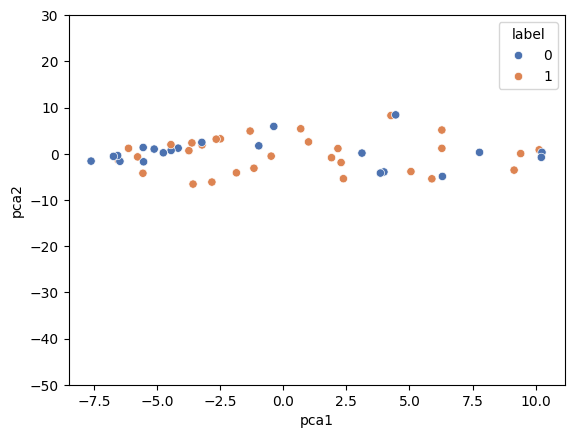

In [161]:
#plot the pca_result with the label as color
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("deep", 2),
    data=pca_result,
    legend="full",
)
plt.ylim(-50, 30)